# CLIP-goals: A Sanity Check

We are interested in determining whether goals described in language will have high similarity with the corresponding goal images and lower similarity with non-goal images. 

This notebook will first serve as a familiarization to the CALVIN dataset and later as an investigation into the sanity check described above

## Imports

In [1]:
import os
import PIL

import yaml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from yaml import load, dump

try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

## Familarizing with the dataset

We first familiarize with the CALVIN dataset, which provides a debug split.

In [3]:
DATA_PATH = "../data/calvin/calvin_debug_dataset/"
train_path = os.path.join(DATA_PATH, "training")
val_path = os.path.join(DATA_PATH, "validation")

### Metadata

There are some files providing metadata. Let's take a look at them:

#### ep_lens and ep_start_end_ids

seems that count the total number of frames and the start and end ids

In [4]:
ep_lens = np.load(os.path.join(train_path, "ep_lens.npy"))
ep_start_end_ids = np.load(os.path.join(train_path, "ep_start_end_ids.npy"))

In [5]:
print(ep_lens)
print(ep_start_end_ids)

2771
[[358482 361252]]


In [6]:
np.subtract.reduce(ep_start_end_ids.squeeze()[::-1])

2770

If I'm understanding this correctly, they only included one episode in the debug dataset, of 2770 frames (or is it 2771?). Normally there would be multiple episodes, so that the ep_lens and ep_start_end_ids files would be more useful, containing the length and start and end ids for each episode. 

Note that the authors use the word episode to refer to a frame. See [this issue comment](https://github.com/mees/calvin/issues/23#issuecomment-1202270412).

#### scene_info

In [7]:
# this is an object array so we need to pass allow_pickle=True
scene_info = np.load(os.path.join(train_path, "scene_info.npy"), allow_pickle=True)

In [8]:
scene_info

array({'calvin_scene_D': [358482, 361252]}, dtype=object)

See [this issue](https://github.com/mees/calvin/issues/14) for an explanation of what is here. TLDR: tells you which of the 4 possible scenes (A, B, C, or D) a given range of frames come from.

#### statistics.yaml

In [9]:
with open(os.path.join(train_path, "statistics.yaml"), "r") as stream:
    try:
        statistics = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [10]:
statistics

{'robot_obs': [{'_target_': 'calvin_agent.utils.transforms.NormalizeVector',
   'mean': [0.039233,
    -0.118554,
    0.507826,
    1.079174,
    -0.083069,
    1.579753,
    0.054622,
    -0.736859,
    1.017769,
    1.792879,
    -2.099604,
    -0.993738,
    1.790842,
    0.586534,
    0.095367],
   'std': [0.150769,
    0.1104,
    0.06253,
    2.883517,
    0.126405,
    0.377196,
    0.030152,
    0.334392,
    0.172714,
    0.240513,
    0.3842,
    0.198596,
    0.158712,
    0.346865,
    0.995442]}],
 'scene_obs': [{'_target_': 'calvin_agent.utils.transforms.NormalizeVector',
   'mean': [0.150934,
    0.119917,
    0.000239,
    0.042049,
    0.487755,
    0.47448,
    0.057482,
    -0.088074,
    0.431237,
    0.046034,
    0.030599,
    0.027333,
    0.062103,
    -0.092833,
    0.430236,
    -0.054962,
    0.019381,
    0.096546,
    0.064944,
    -0.093058,
    0.428381,
    0.024941,
    0.002746,
    -0.031589],
   'std': [0.125757,
    0.09654,
    0.002148,
    0.0419

### Single image

In [11]:
npz_file = np.load(os.path.join(train_path, "episode_0358482.npz"))

In [12]:
[filename for filename in npz_file.files]

['actions',
 'rel_actions',
 'robot_obs',
 'scene_obs',
 'rgb_static',
 'rgb_gripper',
 'rgb_tactile',
 'depth_static',
 'depth_gripper',
 'depth_tactile']

In [13]:
with npz_file as f:
    rgb_static = f["rgb_static"]

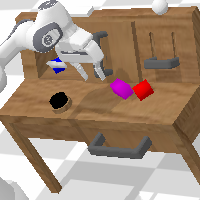

In [15]:
PIL.Image.fromarray(rgb_static)

### Language Annoations

In [18]:
# this is an object array so we need to pass allow_pickle=True

lang_annotations = np.load(
    os.path.join(train_path, "lang_annotations", "auto_lang_ann.npy"), allow_pickle=True
)